In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
import re
import unidecode
import numpy as np
import pandas as pd
import ktrain
from ktrain import text
import wordninja
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

# <font color=red>TRAINING</font>

In [3]:
TRAINING_DATA_PATH = './train.csv'

# for train and validation split 
TEST_SIZE = 0.1
SHUFFLE = True
RANDOM_STATE = 140

# for model
MAXLEN = 40
BATCH_SIZE = 8

# for training model
LEARNING_RATE = 1e-5
EPOCHS = 2

## Load training data

In [4]:
train = pd.read_csv(TRAINING_DATA_PATH)
train=train.drop("id",axis=1)
train.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


## Count number of Positive->0 and Negative->1 in training data

In [5]:
train['label'].value_counts()

0    5894
1    2026
Name: label, dtype: int64

## Data Preprocessing

- [x] lower-case all characters
- [x] remove twitter handles
- [x] remove urls
- [x] replace unidecode characters
- [x] only keep characters
- [x] keep words with length>1 only
- [X] split words like 'whatisthis' to 'what is this'
- [x] remove repeated spaces

In [6]:
def clean_tweet(text):
    
    # lower-case all characters
    text=text.lower()
    
    # remove twitter handles
    text= re.sub(r'@\S+', '',text) 
    
    # remove urls
    text= re.sub(r'http\S+', '',text) 
    text= re.sub(r'pic.\S+', '',text)
      
    # replace unidecode characters
    text=unidecode.unidecode(text)
      
    # regex only keeps characters
    text= re.sub(r"[^a-zA-Z+']", ' ',text)
    
    # keep words with length>1 only
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ') 

    # split words like 'whatisthis' to 'what is this'
    def preprocess_wordninja(sentence):      
        def split_words(x):
            x=wordninja.split(x)
            x= [word for word in x if len(word)>1]
            return x
        new_sentence=[ ' '.join(split_words(word)) for word in sentence.split() ]
        return ' '.join(new_sentence)
    
    text=preprocess_wordninja(text)
 
    # regex removes repeated spaces, strip removes leading and trailing spaces
    text= re.sub("\s[\s]+", " ",text).strip()  
    
    return text

In [7]:
train['tweet']=train['tweet'].apply(lambda x: clean_tweet(x))
train.head()

,label,tweet
0,0,fingerprint pregnancy test android apps beauti...
1,0,finally trans paran silicon case thanks to my ...
2,0,we love this would you go talk make memories u...
3,0,i'm wired know i'm george was made that way ip...
4,1,what amazing service apple won't even talk to ...


## View WordCloud of Positive sample in training data

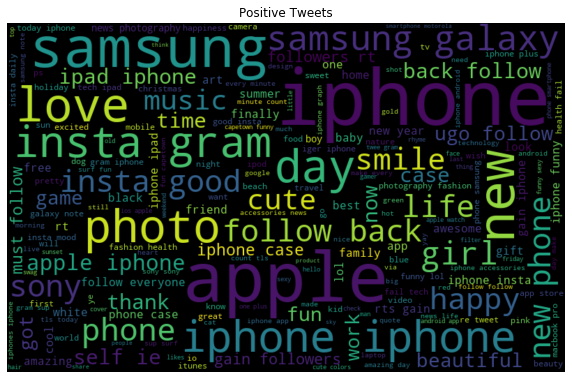

In [8]:
positive= train[train['label']==0]
all_words = ' '.join([text for text in positive['tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=RANDOM_STATE, max_font_size=110).generate(all_words)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Positive Tweets')
plt.axis('off')
plt.show()

## View WordCloud of Negative sample in training data

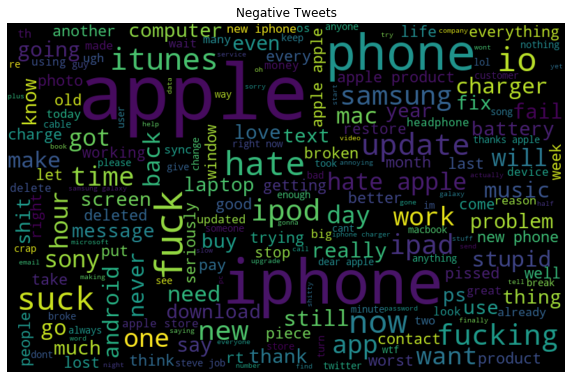

In [9]:
negative= train[train['label']==1]
all_words = ' '.join([text for text in negative['tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=RANDOM_STATE, max_font_size=110).generate(all_words)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Negative Tweets')
plt.axis('off')
plt.show()

## Split training data into train and validation set

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(train['tweet'],
                                                 train['label'],
                                                 test_size=TEST_SIZE,
                                                 shuffle=SHUFFLE,
                                                 random_state=RANDOM_STATE)

## Load the model 'distilbert-base-uncased'

In [11]:
t=text.Transformer('distilbert-base-uncased', maxlen=MAXLEN, class_names=[0,1])

x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_valid=x_valid.to_numpy()
y_valid=y_valid.to_numpy()

trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_valid, y_valid)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=BATCH_SIZE)

preprocessing train...
language: en
train sequence lengths:
	mean : 17
	95percentile : 30
	99percentile : 40


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 27
	99percentile : 39


## Optional: Find learning rate

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
891/891 [==============================] - 122s 137ms/step - loss: 0.4745 - accuracy: 0.7403
Epoch 2/2
891/891 [==============================] - 123s 138ms/step - loss: 0.6301 - accuracy: 0.7243


done.
Visually inspect loss plot and select learning rate associated with falling loss


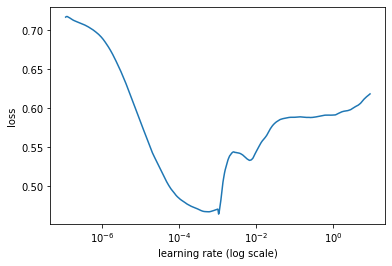

In [12]:
learner.lr_find(show_plot=True, max_epochs=2)

## Reset weights

In [13]:
learner.reset_weights()

Model weights have been reset.


## Train the model

In [14]:
learner.fit_onecycle(LEARNING_RATE, EPOCHS)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/2
891/891 [==============================] - 127s 143ms/step - loss: 0.3287 - accuracy: 0.8462 - val_loss: 0.2010 - val_accuracy: 0.9078
Epoch 2/2
891/891 [==============================] - 126s 142ms/step - loss: 0.1913 - accuracy: 0.9231 - val_loss: 0.1967 - val_accuracy: 0.9192


# <font color=red>TESTING</font>

In [21]:
TESTING_DATA_PATH = './test.csv'
TESTING_DATA_RESULT_PATH = './submit.csv'

## Load testing data

In [16]:
test = pd.read_csv(TESTING_DATA_PATH)
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


## Data Preprocessing

In [17]:
test['tweet']=test['tweet'].apply(lambda x: clean_tweet(x))
test.head()

,id,tweet
0,7921,hate the new iphone upgrade won't let me downl...
1,7922,currently shitting my fucking pants apple imac...
2,7923,i'd like to puts some cd roms on my ipad is th...
3,7924,my ipod is officially dead lost all my and vid...
4,7925,been fighting itunes all night only want the m...


## Test the data

In [18]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
test_result=pd.Series(predictor.predict(test_tweet) for test_tweet in test['tweet'])

## Store the test result

In [19]:
test_csv= pd.DataFrame({'id':pd.Series(test['id']), 'label':test_result})
test_csv.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


## Count number of Positive->0 and Negative->1 in testing data

In [20]:
test_csv['label'].value_counts()

0    1361
1     592
Name: label, dtype: int64

## Save the test result in .csv file

In [22]:
test_csv.to_csv(TESTING_DATA_RESULT_PATH, index=False)

## View metrics

In [23]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       607
           1       0.78      0.90      0.84       185

    accuracy                           0.92       792
   macro avg       0.88      0.91      0.89       792
weighted avg       0.93      0.92      0.92       792



array([[561,  46],
       [ 18, 167]], dtype=int64)

In [24]:
learner.view_top_losses(n=2, preproc=t)

----------
id:175 | loss:5.37 | true:1 | pred:0)

----------
id:675 | loss:3.1 | true:1 | pred:0)

